# Online Food Store Apps Analysis

Anda bekerja di sebuah startup yang menjual produk makanan. Anda perlu mencari tahu perilaku pengguna aplikasi dari perusahaan tersebut.

## Tujuan

Proyek ini berfokus pada analisis perilaku pengguna aplikasi makanan online. Data dipelajari terlebih dahulu corong penjualannya untuk mengetahui total pengguna dari awal masuk aplikasi hingga yang mencapai tahap pembelian. Selanjutnya menganalisis hasil eksperiment dari A/A/B testing dikarenakan adanya kekhawatiran antara Tim Web Designer yang ingin mengubah font untuk keseluruhan aplikasi, dengan Product Manager yang merasa bahwa para pengguna justru akan merasa terganggu dengan desain baru tersebut. Hasil ini akan menentukan font manakah yang akan memberikan hasil terbaik.

### Hipotesis

Para pengguna dibagi menjadi tiga kelompok: dua kelompok kontrol diperlihatkan dengan versi font lama dan satu kelompok uji diperlihatkan dengan versi font terbaru.

Keakuratan pengujian hanya akan diterima jika kedua kelompok kontrol memberikan hasil yang serupa. Jika terdapat perbedaan yang signifikan di antara kedua kelompok A, hal ini dapat membantu kita untuk mengidentifikasi faktor-faktor yang mungkin mendistorsi hasil yang kita peroleh.

### Tahapan

Data tentang setiap entri log disimpan dalam file `/datasets/logs_exp_us.csv`. Tidak ada informasi terkait kualitas data tersebut, sehingga perlu dilakukan pemeriksaan terlebih dahulu sebelum menguji hipotesis.

Proyek ini terdiri dari tiga tahap:

1. Pre-processing Data
    * Data Cleaning
    * Data Preparation
    * Data Optimization
2. Analisis Data Exploratif (EDA) & Analisis Bisnis
    * Data Check
    * Data Study
    * Funnel Study
3. Analisis Data Statistik (Hyphothesis Testing & A/A/B Testing) 

## 1. Pre-processing Data

In [1]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import plotly.express as px
import math as mth

from datetime import date, timedelta
import datetime as dt

# Turn warnings off
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown, display

In [2]:
# Define printmd() function to print code in blue color.
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### 1.1. Memuat Data

In [3]:
# Read datasets
logs_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/logs_exp_us.csv', sep='\t')

# Assign names to the dataframe
logs_data.name = 'logs_exp'

# Print a concise summary of the dataFrames with pandas.DataFrame.info() method.
printmd("{}".format(logs_data.name), color='blue')
logs_data.info()
display(logs_data.head())

<span style='color:blue'>logs_exp</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Deskripsi logs_data**: 

- `EventName` — nama peristiwa
- `DeviceIDHash` — ID unik pengguna
- `EventTimestamp` — waktu peristiwa
- `ExpId`  — nomor eksperimen: 246 dan 247 untuk kelompok kontrol, 248 untuk kelompok uji

**Kesimpulan:**

* Nama pada kolom sebaiknya dalam huruf kecil dengan tiap kata diberi "_".
* Tidak terlihat nilai yang hilang pada data.
* Perlu ditambahkan kolom tanggal dan waktu, serta kolom terpisah untuk tanggal.
* Data cukup besar yaitu 7.5+ MB, mungkin bisa di optimalkan.

### 1.2. Mengeksplorasi Data Awal

In [4]:
# Check total missing values descending
logs_data.isna().sum().sort_values(ascending=False)

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [5]:
# Check duplicated data
logs_data.duplicated().sum()

413

**Kesimpulan Sementara:**

* Tidak terdapat nilai yang hilang pada data.
* Sebanyak 413 data adalah duplikat. Duplikat dapat di drop.

In [6]:
logs_data.drop_duplicates(inplace=True)

In [7]:
# Check duplicated data
logs_data.duplicated().sum()

0

**Kesimpulan:**

* Nilai duplikat pada data telah di hapus.

### 1.3. Preparasi Data

In [8]:
# Rename the columns
logs_data.columns =['event_name','user_id','timestamp','exp_id']

In [9]:
# Adding a date and time column and a separate column for dates.
logs_data['datetime'] = pd.to_datetime(logs_data['timestamp'],unit='s')
logs_data['date'] = logs_data['datetime'].dt.date

logs_data.head()

,event_name,user_id,timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
logs_data.info()
print()
for c in logs_data.columns:
    print("Number of unique values in column '{}': {}".format(c,len(logs_data[c].unique())))
    print(logs_data[c].unique())
    print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   datetime    243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB

Number of unique values in column 'event_name': 5
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

Number of unique values in column 'user_id': 7551
[4575588528974610257 7416695313311560658 3518123091307005509 ...
 6660805781687343085 7823752606740475984 3454683894921357834]

Number of unique values in column 'timestamp': 176654
[1564029816 1564053102 1564054127 ... 1565212

**Kesimpulan Sementara:**

* Kolom `event_name` dapat diubah menjadi katagoris untuk mengoptimalkan memori
* kolom `date` dapat diubah menjadi datetime untuk mengoptimalkan memori

In [11]:
# Optimization memory usage
logs_data['event_name'] = logs_data['event_name'].astype('category')
logs_data['date'] = pd.to_datetime(logs_data['date'])

In [12]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  category      
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   datetime    243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), int64(3)
memory usage: 11.4 MB


**Kesimpulan:**

* `logs_data` telah dioptimasi dan siap dianalisis.

## 2. Analisis Data Exploratif (EDA)

### 2.1. Mempelajari Parameter Inti 

Untuk mempelajari outlier yang memengaruhi bentuk dan kemudahan pembacaan analisis, dilakukan pendekatan kepada beberapa parameter berikut:

- Berapa banyak peristiwa yang tercatat dalam log?,
- Berapa banyak pengguna yang tercatat dalam log?,
- Berapa jumlah rata-rata peristiwa per pengguna?,
- Periode waktu manakah yang dicakup oleh data? 
- Apakah kehilangan banyak peristiwa dan pengguna saat menyingkirkan data lama?, dan
- Pastikan memiliki pengguna dari ketiga kelompok eksperimen. 

In [13]:
printmd('Terdapat {} events di dalam logs.'.format(len(logs_data)), color='green')
printmd('Terdapat {} pengguna yang tercatat di dalam logs.'.format(len(logs_data['user_id'].unique())), color='green')
printmd('Rata-rata {} peristiwa per pengguna yang tercatat di dalam logs.'.format(int(logs_data.groupby(by=['user_id']).agg({'event_name':'count'}).mean()[0])), color='green')

<span style='color:green'>Terdapat 243713 events di dalam logs.</span>

<span style='color:green'>Terdapat 7551 pengguna yang tercatat di dalam logs.</span>

<span style='color:green'>Rata-rata 32 peristiwa per pengguna yang tercatat di dalam logs.</span>

In [14]:
printmd('Peristiwa waktu yang dicakup oleh data adalah:')
stats_period = logs_data['datetime'].describe()

print('Minimum date adalah: {}'
      .format(stats_period['first']))
print('Maksimum date adalah: {}'
      .format(stats_period['last']))

<span style='color:None'>Peristiwa waktu yang dicakup oleh data adalah:</span>

Minimum date adalah: 2019-07-25 04:43:36
Maksimum date adalah: 2019-08-07 21:15:17


**Kesimpulan Sementara:**

Data mencakup log dari 2 minggu periode, yaitu 14 hari. Namun perlu dipastikan kembali bahwa data yang dimiliki sama lengkapnya untuk seluruh periode. Jika kejadian yang lebih lama muncul di log beberapa pengguna karena alasan teknis, hal ini dapat mengubah gambaran secara keseluruhan. Untuk itu, kami memplot histogram berdasarkan tanggal dan waktu.

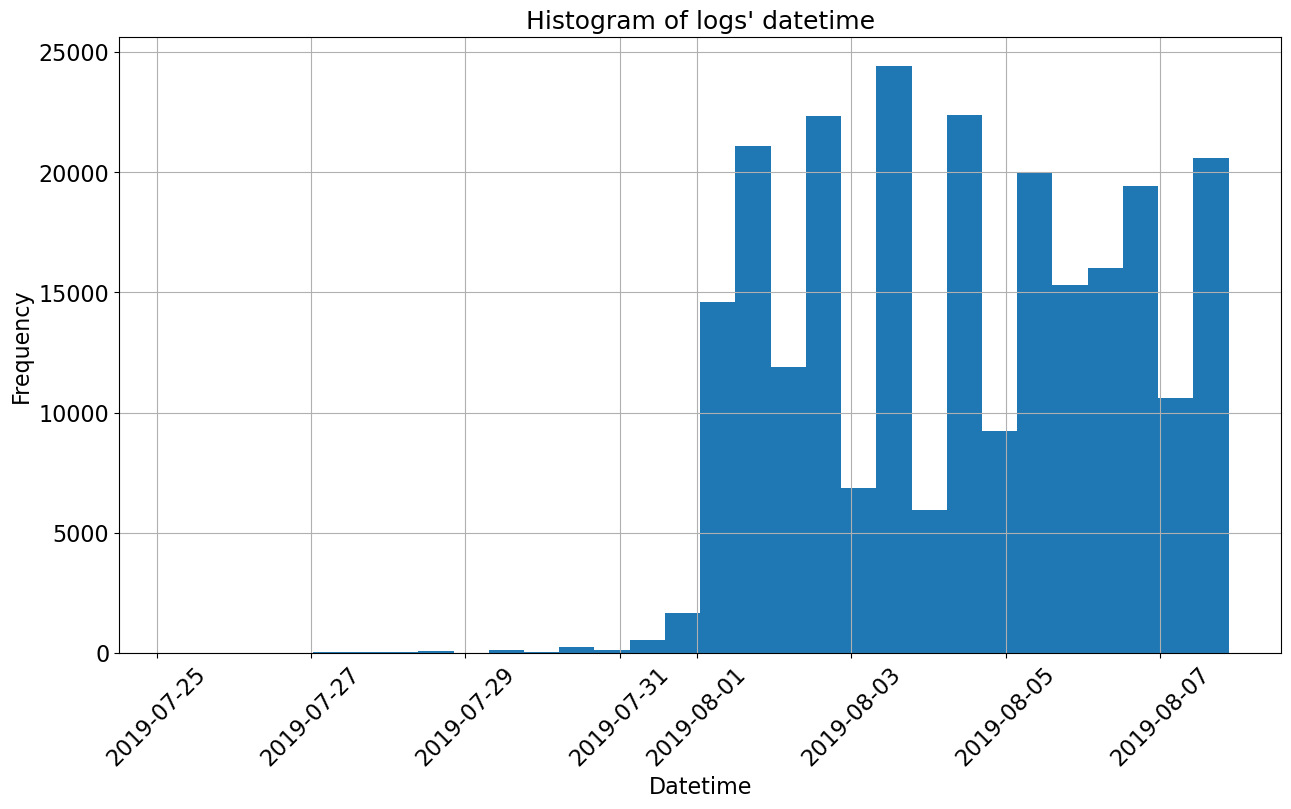

In [15]:
# Create a histogram of the revenue column
plt.figure(figsize=(15, 8))
logs_data['datetime'].hist(bins=30)
plt.title("Histogram of logs' datetime" , fontsize=18)
plt.xlabel('Datetime', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.ylabel('Frequency', fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Kesimpulan Sementara:**

Dari histogram, kita melihat bahwa sebagian besar log berasal dari minggu kedua. Data mulai lengkap sejak awal minggu kedua, yaitu "2019-08-01". Dengan demikian, kami membuang data dari minggu pertama.

Perhatikan bahwa peristiwa yang lebih lama dapat berakhir di log pengguna karena alasan teknis. Jadi, kita harus memberi tahu pengembang agar mereka memeriksa mengapa hal ini terjadi.

In [16]:
logs_complete = logs_data.loc[logs_data['datetime'] >= "2019-08-01"].copy()
logs_complete['datetime'].describe()

count                  240887
unique                 174044
top       2019-08-01 14:40:35
freq                        9
first     2019-08-01 00:07:28
last      2019-08-07 21:15:17
Name: datetime, dtype: object

Apakah kehilangan banyak peristiwa dan pengguna saat menyingkirkan data lama?

In [17]:
print('Terdapat {} logs yang terekam di minggu pertama.' .format((logs_data['datetime'] < "2019-08-01").sum()))

Terdapat 2826 logs yang terekam di minggu pertama.


In [18]:
first_week_users = logs_data.loc[logs_data['datetime'] < "2019-08-01", 'user_id'].unique()

print('The logs from the first week belong to {} users.'
      .format(len(first_week_users)))
print('Number of users for which logs were recorded only in the first week: {}'.
      format(len(first_week_users)-
             len(logs_complete.loc[logs_complete['user_id'].isin(first_week_users), 'user_id'].unique())))

The logs from the first week belong to 1451 users.
Number of users for which logs were recorded only in the first week: 17


**Kesimpulan Sementara:**

Kami menemukan bahwa dengan membuang data untuk minggu pertama, kami hanya kehilangan 17 pengguna dari 7551 pengguna unik dan 2826 log secara keseluruhan. Ini setara dengan sekitar 0,225% pengguna dan sekitar 1,16% dari jumlah total log. Dengan demikian, dengan mengecualikan data yang lebih lama, kami tidak kehilangan jumlah kejadian atau pengguna yang signifikan. Untuk sisa proyek ini, kita akan bekerja dengan kerangka data `logs_complete`.

Agar pengujian A/B akurat, kita perlu memastikan bahwa semua grup berisi jumlah pengguna yang sama dan tidak ada pengguna yang ditugaskan ke lebih dari satu grup.

In [19]:
print('Jumlah pengguna yang ditetapkan ke setiap grup:')
print(logs_complete.groupby(by=['exp_id'])['user_id'].nunique())

print('Jumlah pengguna unik dalam percobaan:{} '.format(logs_complete['user_id'].nunique()))
print('Jumlah jumlah pengguna unik di setiap grup:{}'
      .format(logs_complete.groupby(by=['exp_id'])['user_id'].nunique().sum()))

Jumlah pengguna yang ditetapkan ke setiap grup:
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64
Jumlah pengguna unik dalam percobaan:7534 
Jumlah jumlah pengguna unik di setiap grup:7534


**Kesimpulan:**

Setiap kelompok memiliki sekitar 2500 pengguna. Jadi, semua kelompok eksperimen ditugaskan dengan jumlah pengguna yang hampir sama. Selain itu, semua pengguna hanya ditugaskan ke satu kelompok selama percobaan.

### 2.2. Mempelajari Corong Peristiwa

**a. Melihat peristiwa apa saja yang ada dalam log dan berapa banyak frekuensi kemunculannya.**

In [20]:
logs_events = logs_complete.groupby(by=['event_name'])['timestamp'].count().sort_values(ascending=False)
logs_events = logs_events.rename('log_counts')
print('Counts of logs by event type:')
display(logs_events)

Counts of logs by event type:


event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: log_counts, dtype: int64

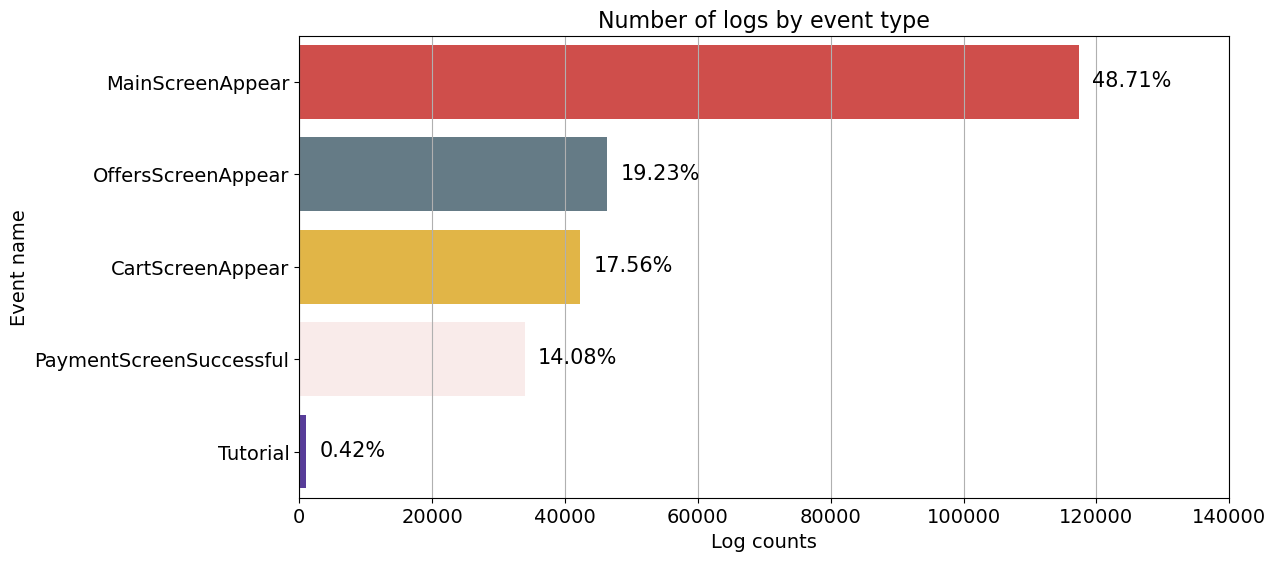

In [21]:
bar_colors = ["#E53935", "#607D8B", "#FBC02D", "#FBE9E7", "#512DA8"]

plt.figure(figsize=(12, 6))
ax = sns.countplot(y='event_name', data=logs_complete, orient='h', 
                   order = logs_complete.groupby(by=['event_name'])['timestamp'].count().sort_values(ascending=False).index,
                   palette = bar_colors)
ax.set_title('Number of logs by event type', fontsize=16)
ax.set_xlabel('Log counts', fontsize=14)
ax.set_ylabel('Event name', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(right=140000)
ax.xaxis.grid()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+2000, i.get_y()+.45, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')

**Kesimpulan:**

* Berdasarkan data dari plot, kurang dari 0,5% dari log adalah tutorial. Hal ini tidak asing karena pengguna akan membaca tutorial satu kali atau bahkan melewatinya. Terutama dalam konteks toko makanan online. Sehingga event Tutorial tidak perlu dimasukkan ke dalam funnel.
* Dilihat dari 4 event lainnya, data menunjukkan bahwa frekuensi kemunculan event diurutkan sebagai berikut: 

MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful.

**b. Menentukan jumlah serta proporsi pengguna yang melakukan tindakan.**

In [22]:
logs_event_2 = logs_complete.groupby(by=['event_name'])['user_id'].nunique().sort_values().reset_index()
logs_event_2 = logs_event_2.rename({'user_id':'user_counts'}, axis=1)
print('Counts of users who performed the given actions at least once:')
display(logs_event_2)

Counts of users who performed the given actions at least once:


,event_name,user_counts
0,Tutorial,840
1,PaymentScreenSuccessful,3539
2,CartScreenAppear,3734
3,OffersScreenAppear,4593
4,MainScreenAppear,7419


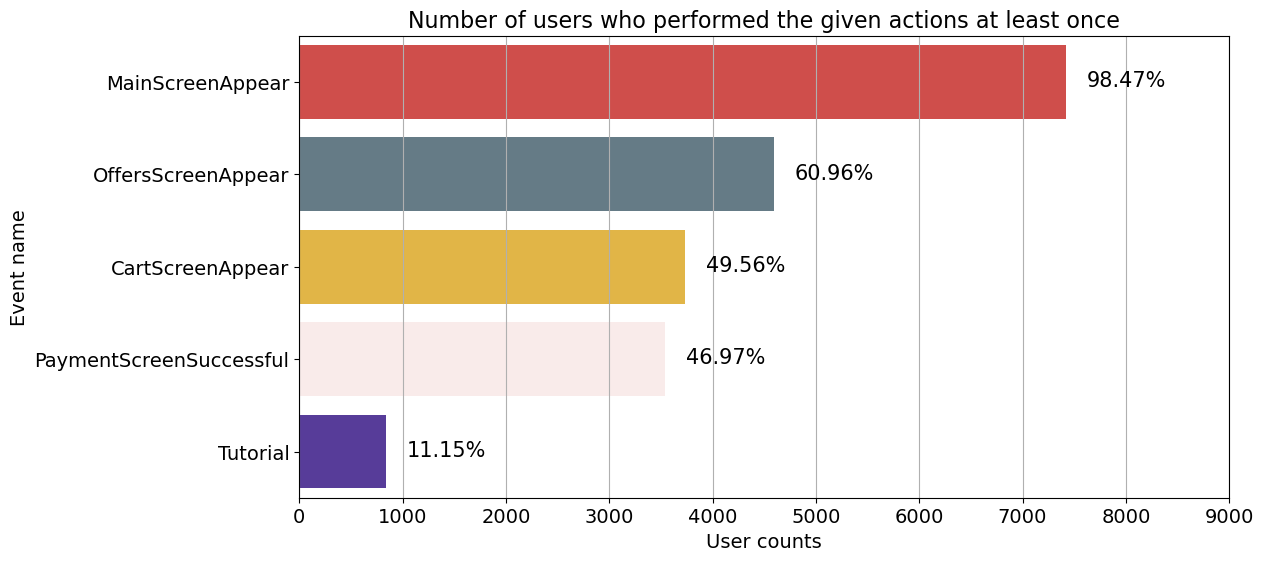

In [23]:
bar_colors = ["#E53935", "#607D8B", "#FBC02D", "#FBE9E7", "#512DA8"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='user_counts', y="event_name", data=logs_event_2, orient='h', palette=bar_colors,
                 order=logs_event_2.sort_values('user_counts', ascending=False)['event_name'])
ax.set_title('Number of users who performed the given actions at least once', fontsize=16)
ax.set_xlabel('User counts', fontsize=14)
ax.set_ylabel('Event name', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(right=9000)
ax.xaxis.grid()

# set individual bar lables using above list
total = logs_complete['user_id'].nunique()

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+200, i.get_y()+.45, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')

**Kesimpulan:**

* Berdasarkan data dari plot, jumlah pengguna yang melakukan event mengikuti urutan yang sama dengan frekuensi event. Yaitu:

MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful.

In [24]:
#let's calculate the proportion of users who performed the action only once
use = logs_complete.groupby(['user_id','event_name']).agg({'timestamp':'count'}).reset_index()
once_use = use.query('timestamp==1')

func = lambda x: x.nunique()
once_use_pv = once_use.pivot_table(index = 'event_name', values = 'user_id', aggfunc = func
).reset_index().sort_values(by = 'user_id', ascending = False)
once_use_pv

,event_name,user_id
4,Tutorial,756
2,OffersScreenAppear,681
3,PaymentScreenSuccessful,574
0,CartScreenAppear,472
1,MainScreenAppear,246


In [25]:
several_use=use.query('timestamp>1')

func=func = lambda x: x.nunique()
several_use_pv = several_use.pivot_table(
    index='event_name', values='user_id', aggfunc=func
).reset_index().sort_values(by='user_id', ascending=False)
several_use_pv

,event_name,user_id
1,MainScreenAppear,7173
2,OffersScreenAppear,3912
0,CartScreenAppear,3262
3,PaymentScreenSuccessful,2965
4,Tutorial,84


In [26]:
proportion = several_use_pv.merge(once_use_pv, left_on=['event_name'], right_on=['event_name']) 
proportion.columns=['event_name','users_several_uses','users_once_uses']
proportion['proportion, %']=round(proportion['users_once_uses']/proportion['users_several_uses']*100)
proportion

,event_name,users_several_uses,users_once_uses,"proportion, %"
0,MainScreenAppear,7173,246,3.0
1,OffersScreenAppear,3912,681,17.0
2,CartScreenAppear,3262,472,14.0
3,PaymentScreenSuccessful,2965,574,19.0
4,Tutorial,84,756,900.0


**Kesimpulan:**

* Berdasarkan data, dapat terlihat bahwa melalui tahap MainScreenAppear melewati 7419 pengguna unik, OffersScreenAppear - 4593, CartScreenAppear - 3734, PaymentScreenSuccessful - 3539, Tutorial - 840.
* Berdasarkan data, pengguna unik yang melewati tahap-tahap ini hanya sekali, ditemukan bahwa melalui Tutorial melewati 756 pengguna unik (900% vs pengguna yang melewati tahap ini beberapa kali), OffersScreenAppear - 681 (17%), PaymentScreenSuccessful - 572 (19%), CartScreenAppear - 472 (14%) dan melalui MainScreenAppear - 246 (3%).

**c. Menentukan urutan dari event tersebut.**

Berdasarkan temuan sebelumnya, asumsi kami adalah bahwa urutannya adalah sebagai berikut: 

0. Tutorial
1. MainScreenAppear stage
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

**Kesimpulan:**
Kami menduga bahwa Tutorial bukanlah bagian dari satu urutan karena sebagian besar pengguna melewatkan langkah ini dan mereka yang melewatinya, umumnya hanya melakukannya satu kali.

**d. Menentukan corong peristiwa.**

In [27]:
# Filter out Tutorial event
logs_notutorial = logs_complete.loc[~(logs_complete['event_name'] == 'Tutorial')].copy()

# Plotly funnel
funnel_by_groups = []

for g in logs_notutorial['exp_id'].unique():
    temp_grp = logs_notutorial.loc[logs_notutorial['exp_id'] == g].groupby(by=['event_name', 'exp_id'])['user_id'].nunique().reset_index().sort_values(by=['user_id'], ascending=False)
    funnel_by_groups.append(temp_grp)

funnel_by_groups = pd.concat(funnel_by_groups)

fig = px.funnel(funnel_by_groups, x='user_id', y='event_name', color='exp_id', title='Event funnel for the number of users who performed given action')

fig.update_layout(
    autosize=False,
    width=900,
    height=400,
    legend=dict(
        yanchor="top",
        y=0.4,
        xanchor="right",
        x=0.2
    )
)

fig.show()

In [28]:
funnel_share = (logs_complete.groupby(by=['event_name'])['user_id'].nunique().
                sort_values(ascending=False).reset_index())
funnel_share['pct_chg'] = (funnel_share['user_id'].pct_change()*-1*100)
display(funnel_share.iloc[0:4])

,event_name,user_id,pct_chg
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,38.091387
2,CartScreenAppear,3734,18.702373
3,PaymentScreenSuccessful,3539,5.222282


**e. Menentuan tahapan yang  kehilangan banyak pengguna.**

**Kesimpulan:**
Berdasarkan temuan sebelumnya aplikasi ini kehilangan sebagian besar pengguna saat bertransisi dari halaman utama ke halaman penawaran dengan kehilangan sekitar 38% pengguna.

**e. Menentuan persentase pengguna yang berhasil menyelesaikan seluruh tahapan, dari peristiwa pertama hingga pembayaran.**

In [29]:
converted = logs_complete.query('event_name == "PaymentScreenSuccessful"')['user_id']

In [30]:
print(round(converted.nunique()/logs_complete['user_id'].nunique()*100),'%')

47 %


**Kesimpulan:**
Kami menemukan bahwa dari 7534 pengguna yang berpartisipasi dalam percobaan kami, 3539 di antaranya melakukan pembelian. Ini setara dengan sekitar 47% pengguna. Jadi hampir setengah dari pengguna berhasil menyelesaikan pembelian mereka, yang merupakan tingkat konversi yang sangat tinggi.

## 3. Analisis Data Statistik (Hyphothesis Testing & A/A/B Testing)

### 3.1. Berapa banyak pengguna yang ada di setiap kelompok?

In [31]:
control_1 = logs_complete.loc[logs_complete['exp_id'] == 246, 'user_id'].unique()
control_2 = logs_complete.loc[logs_complete['exp_id'] == 247, 'user_id'].unique()
test = logs_complete.loc[logs_complete['exp_id'] == 248, 'user_id'].unique()

print('Terdapat {} pengguna di first control group.'.format(len(control_1)))
print('Terdapat {} pengguna di second control group.'.format(len(control_2)))
print('Terdapat {} pengguna di test group.'.format(len(test)))

Terdapat 2484 pengguna di first control group.
Terdapat 2513 pengguna di second control group.
Terdapat 2537 pengguna di test group.


**Kesimpulan:**
Berdasarkan Untuk pengujian A/A yang sukses, jumlah pengguna dalam kelompok yang berbeda tidak boleh berbeda lebih dari 1%. Di sini, jumlah pengguna di antara dua kelompok kontrol berbeda sekitar 0,94%. Jadi, ini adalah awal yang baik.

### 3.2. Apakah ada perbedaan yang signifikan secara statistik antara sampel dari kelompok eksperimen?

In [32]:
logs_pivot = logs_complete.pivot_table(index='event_name', values='user_id', columns='exp_id', 
                       aggfunc=lambda x: x.nunique()).reset_index()
display(logs_pivot)

exp_id,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


**Kesimpulan Sementara:**

* Dari tabel tersebut, event paling populer adalah MainScreenAppear.

Untuk menguji signifikansi statistik antara kelompok-kelompok tersebut, di bawah ini kami mendefinisikan fungsi pengujian hipotesis yang akan digunakan untuk melakukan Z-tests.

In [33]:
def check_hypothesis(group1, group2, event, alpha=0.05):
    print('Considered action:', event)
    #let's start with successes, using 
    successes1 = logs_pivot.loc[logs_pivot['event_name']==event, group1].iloc[0]
    successes2 = logs_pivot.loc[logs_pivot['event_name']==event, group2].iloc[0]
    
    #for trials we can go back to original df or used a pre-aggregated data
    trials1 = logs_complete.loc[logs_complete['exp_id']==group1, 'user_id'].nunique()
    trials2 = logs_complete.loc[logs_complete['exp_id']==group2, 'user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1
    print('Persentase pengguna yang melakukan tindakan {} dalam grup {}.'.format(event, group1))

   #proportion for success in the second group
    p2 = successes2/trials2
    print('Persentase pengguna yang melakukan tindakan {} dalam grup {}.'.format(event, group2))

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = st.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Tolak hipotesis nol untuk {} dan kelompok {} & {}."
              .format(event, group1, group2))
    else:
        print("Gagal menolak hipotesis nol untuk {} dan grup {} & {}."
              .format(event, group1, group2)) 

Fungsi pengujian hipotesis yang telah kita definisikan cocok untuk menguji kesetaraan proporsi populasi. Hipotesis nol dan hipotesis alternatif kita dapat dirumuskan sebagai berikut untuk dua kelompok yang akan kita bandingkan untuk suatu peristiwa tertentu:

* **H0 (Null Hypothesis):** Tidak ada perbedaan yang signifikan secara statistik dalam proporsi pengguna yang melakukan tindakan peristiwa tertentu dari kedua kelompok.
* **H1 (Alternative Hypothesis):** Terdapat perbedaan yang signifikan secara statistik dalam proporsi pengguna yang melakukan tindakan peristiwa tertentu dari kedua kelompok. 

(alpha = 0.05).

Untuk semua kejadian dalam log kami, kami menguji signifikansi statistik secara terpisah antara berbagai kelompok. Kami mulai dengan menguji dua kelompok kontrol dalam A/A testing.

In [34]:
test_count = 0
for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(246,247, i, alpha=0.05)
    print()

<span style='color:red'>Hypothesis test #1</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 247.
p-value:  0.22883372237997213
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #2</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 247.
p-value:  0.7570597232046099
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #3</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 247.
p-value:  0.2480954578522181
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #4</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 246.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 247.
p-value:  0.11456679313141849
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 246 & 247.



<span style='color:red'>Hypothesis test #5</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 246.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 247.
p-value:  0.9376996189257114
Gagal menolak hipotesis nol untuk Tutorial dan grup 246 & 247.



**Kesimpulan:**
Kami menemukan bahwa tidak ada perbedaan yang signifikan secara statistik antara kelompok A/A dalam eksperimen kami.

Bagaimana dengan kelompok dengan font yang diubah? Sekarang kita menguji apakah ada perbedaan yang signifikan secara statistik antara sampel untuk kelompok 248 dan kelompok kontrol.

Di sini kita ulangi pengujian hipotesis untuk kelompok dengan font yang diubah. Pertama-tama, mari kita bandingkan hasilnya dengan hasil dari masing-masing kelompok kontrol untuk setiap peristiwa secara terpisah. Kita mulai dengan pengujian untuk kelompok 246 dan 248.

In [35]:
for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(246,248, i, alpha=0.05)
    print()

<span style='color:red'>Hypothesis test #6</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.07842923237520116
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #7</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.2949721933554552
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #8</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.20836205402738917
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #9</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 246.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.2122553275697796
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 246 & 248.



<span style='color:red'>Hypothesis test #10</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 246.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.8264294010087645
Gagal menolak hipotesis nol untuk Tutorial dan grup 246 & 248.



**Kesimpulan:**
Perbandingan antara kelompok kontrol pertama dan kelompok uji tidak menunjukkan adanya perbedaan yang signifikan secara statistik.

Selanjutnya, kami melanjutkan dengan pengujian untuk grup 247 dan 248.

In [36]:
for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(247,248, i, alpha=0.05)
    print()

<span style='color:red'>Hypothesis test #11</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.5786197879539783
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #12</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.4587053616621515
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #13</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.9197817830592261
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #14</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 247.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.7373415053803964
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 247 & 248.



<span style='color:red'>Hypothesis test #15</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 247.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.765323922474501
Gagal menolak hipotesis nol untuk Tutorial dan grup 247 & 248.



**Kesimpulan:**
Perbandingan antara kelompok kontrol kedua dan kelompok uji juga tidak menunjukkan perbedaan yang signifikan secara statistik.

Sekarang mari kita bandingkan hasilnya dengan hasil gabungan untuk kelompok kontrol. Pertama-tama kita perlu menggabungkan kelompok 246 dan 247. Kita berikan id 245 kepada kelompok kontrol gabungan dan kita perbaiki fungsi pengujian kita.

In [37]:
logs_complete_comb = logs_complete.copy()

logs_complete_comb['exp_id'] = logs_complete_comb['exp_id'].apply(lambda x: 
                                                                245 if (x==246) | (x==247)
                                                                else 248)

logs_pivot_comb = logs_complete_comb.pivot_table(index='event_name', values='user_id', columns='exp_id', 
                       aggfunc=lambda x: x.nunique()).reset_index()
display(logs_pivot_comb)

def check_hypothesis_2(group1, group2, event, alpha=0.05):
    print('Considered action:', event)
    #let's start with successes, using 
    successes1 = logs_pivot_comb.loc[logs_pivot['event_name']==event, group1].iloc[0]
    successes2 = logs_pivot_comb.loc[logs_pivot['event_name']==event, group2].iloc[0]
    
    #for trials we can go back to original df or used a pre-aggregated data
    trials1 = logs_complete_comb.loc[logs_complete_comb['exp_id']==group1, 'user_id'].nunique()
    trials2 = logs_complete_comb.loc[logs_complete_comb['exp_id']==group2, 'user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1
    print('Persentase pengguna yang melakukan tindakan {} dalam grup {}.'.format(event, group1))

   #proportion for success in the second group
    p2 = successes2/trials2
    print('Persentase pengguna yang melakukan tindakan {} dalam grup {}.'.format(event, group2))

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = st.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Tolak hipotesis nol untuk {} dan kelompok {} & {}."
              .format(event, group1, group2))
    else:
        print("Gagal menolak hipotesis nol untuk {} dan grup {} & {}."
              .format(event, group1, group2)) 

exp_id,event_name,245,248
0,CartScreenAppear,2504,1230
1,MainScreenAppear,4926,2493
2,OffersScreenAppear,3062,1531
3,PaymentScreenSuccessful,2358,1181
4,Tutorial,561,279


In [38]:
for i in logs_pivot_comb['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis_2(245, 248, i, alpha=0.05)
    print()

<span style='color:red'>Hypothesis test #16</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.18175875284404386
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #17</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.29424526837179577
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #18</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.43425549655188256
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #19</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 245.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.6004294282308704
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 245 & 248.



<span style='color:red'>Hypothesis test #20</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 245.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.764862472531507
Gagal menolak hipotesis nol untuk Tutorial dan grup 245 & 248.



**Kesimpulan:**

* Perbandingan antara kelompok kontrol gabungan dan kelompok uji juga tidak menunjukkan perbedaan yang signifikan secara statistik. 
* Dengan demikian, kami menyimpulkan bahwa font yang diubah tidak berdampak negatif pada pengguna atau meningkatkan pengalaman mereka.

### 3.3. Bonferroni correction

Mari kita bahas tingkat signifikansi yang kami tetapkan untuk menguji hipotesis statistik. Untuk setiap perbandingan berpasangan yang kami buat, kami menetapkan tingkat signifikansi sebesar 0.05 (5%). Dalam satu perbandingan berpasangan, probabilitas bahwa pengujian akan menghasilkan hasil positif palsu sama dengan tingkat signifikansi. Secara keseluruhan, kami menguji 20 hipotesis, sehingga kami telah melakukan 4 perbandingan berpasangan untuk setiap peristiwa. Dalam kasus ini, tingkat kesalahan family-wise error rate (FWER), yaitu probabilitas setidaknya satu hasil positif palsu adalah 18,55%. Untuk meminimalkan FWER, salah satu koreksi yang paling umum dan paling mendekati tingkat signifikansi yang diperlukan dilakukan melalui prosedur Bonferroni. Tingkat signifikansi pada masing-masing m perbandingan dipilih m kali lebih kecil dari tingkat signifikansi yang diperlukan untuk satu perbandingan. Jadi, dengan menerapkan koreksi Bonferroni, kami membagi tingkat signifikansi 5% dengan jumlah perbandingan 4. Ini memberi kita alpha baru sebesar 1,25%. Mari kita ulangi langkah-langkah sebelumnya untuk melihat apakah kesimpulan kita berubah.

In [39]:
test_count = 0

for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(246, 247, i, alpha=0.0125)
    print()

for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(246, 248, i, alpha=0.0125)
    print()
    
for i in logs_pivot['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis(247, 248, i, alpha=0.0125)
    print()
    
for i in logs_pivot_comb['event_name'].unique():
    test_count += 1
    printmd('Hypothesis test #{}'.format(test_count), color='red')
    check_hypothesis_2(245, 248, i, alpha=0.0125)
    print()

<span style='color:red'>Hypothesis test #1</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 247.
p-value:  0.22883372237997213
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #2</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 247.
p-value:  0.7570597232046099
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #3</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 247.
p-value:  0.2480954578522181
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 246 & 247.



<span style='color:red'>Hypothesis test #4</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 246.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 247.
p-value:  0.11456679313141849
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 246 & 247.



<span style='color:red'>Hypothesis test #5</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 246.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 247.
p-value:  0.9376996189257114
Gagal menolak hipotesis nol untuk Tutorial dan grup 246 & 247.



<span style='color:red'>Hypothesis test #6</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.07842923237520116
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #7</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.2949721933554552
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #8</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 246.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.20836205402738917
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 246 & 248.



<span style='color:red'>Hypothesis test #9</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 246.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.2122553275697796
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 246 & 248.



<span style='color:red'>Hypothesis test #10</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 246.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.8264294010087645
Gagal menolak hipotesis nol untuk Tutorial dan grup 246 & 248.



<span style='color:red'>Hypothesis test #11</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.5786197879539783
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #12</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.4587053616621515
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #13</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 247.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.9197817830592261
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 247 & 248.



<span style='color:red'>Hypothesis test #14</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 247.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.7373415053803964
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 247 & 248.



<span style='color:red'>Hypothesis test #15</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 247.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.765323922474501
Gagal menolak hipotesis nol untuk Tutorial dan grup 247 & 248.



<span style='color:red'>Hypothesis test #16</span>

Considered action: CartScreenAppear
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan CartScreenAppear dalam grup 248.
p-value:  0.18175875284404386
Gagal menolak hipotesis nol untuk CartScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #17</span>

Considered action: MainScreenAppear
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan MainScreenAppear dalam grup 248.
p-value:  0.29424526837179577
Gagal menolak hipotesis nol untuk MainScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #18</span>

Considered action: OffersScreenAppear
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 245.
Persentase pengguna yang melakukan tindakan OffersScreenAppear dalam grup 248.
p-value:  0.43425549655188256
Gagal menolak hipotesis nol untuk OffersScreenAppear dan grup 245 & 248.



<span style='color:red'>Hypothesis test #19</span>

Considered action: PaymentScreenSuccessful
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 245.
Persentase pengguna yang melakukan tindakan PaymentScreenSuccessful dalam grup 248.
p-value:  0.6004294282308704
Gagal menolak hipotesis nol untuk PaymentScreenSuccessful dan grup 245 & 248.



<span style='color:red'>Hypothesis test #20</span>

Considered action: Tutorial
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 245.
Persentase pengguna yang melakukan tindakan Tutorial dalam grup 248.
p-value:  0.764862472531507
Gagal menolak hipotesis nol untuk Tutorial dan grup 245 & 248.



**Kesimpulan:**

* Pada langkah ini, kami menganalisis hasil uji A/A/B. Kami menjalankan beberapa perbandingan berpasangan antara berbagai kelompok uji untuk memeriksa apakah hasilnya berbeda secara signifikan secara statistik. Kami menjalankan semua uji hipotesis, yang didasarkan pada Z-skor, baik tanpa maupun dengan koreksi Bonferroni.
* Data eksperimen kami terdiri dari 5 jenis kejadian yang dicatat untuk 2 kelompok kontrol dan satu kelompok uji. Untuk setiap jenis kejadian, kami melakukan 4 perbandingan berpasangan: 3 di antara 3 kelompok dan 1 di antara gabungan kelompok kontrol dan kelompok uji. Dengan demikian, kami memiliki total 20 uji statistik.

## Kesimpulan Umum

#### A. Pra-pemrosesan

Dari eksplorasi pra-pemrosesan data, dapat disimpulkan bahwa:
1. Data menyangkut data log food online store app. Data tidak terdapat nilai yang hilang.
2. Duplikat data ditemukan sebanyak 413 data, dan dihapus. Apabila ada kesalahanpun tidak akan mempengaruhi keseluruhan data.
3. Untuk mempermudah analisis data, dilakukan cleaning serta optimasi data.


#### B. Analisis Data Esksploratif (EDA)

Dari hasil analisis data esksploratif, dapat disimpulkan bahwa:

1. Data log yang diperoleh diketahui bahwa, terdapat 243713 events di dalam logs, 7551 pengguna yang tercatat di dalam logs, serta rata-rata 32 peristiwa per pengguna yang tercatat di dalam logs.
2. Peristiwa waktu yang dicakup oleh data adalah 14 hari.
3. Minggu pertama di buang karena termasuk outlier dan tidak akan mempengaruhi data. 
4. Setiap kelompok memiliki sekitar 2500 pengguna dan semua kelompok secara rata sehingga pengujian A/B  dapat akurat.
5. Corong bisnis log data secara berurutan adalah MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful.

#### C. Analisis Data Statistik (Hyphothesis Testing & A/A/B Testing)

Dari hasil analisis data statistik, dapat disimpulkan bahwa:

1. Hasil uji A/A/B tidak menunjukkan perbedaan yang signifikan secara statistik antara tindakan yang dilakukan oleh pengguna yang melihat font lama dan yang melihat font baru baik tanpa maupun dengan koreksi Bonferroni.
2. Data eksperimen kami terdiri dari 5 jenis kejadian yang dicatat untuk 2 kelompok kontrol dan satu kelompok uji. Untuk setiap jenis kejadian, kami melakukan 4 perbandingan berpasangan: 3 di antara 3 kelompok dan 1 di antara gabungan kelompok kontrol dan kelompok uji. Dengan demikian, kami memiliki total 20 uji statistik.

#### Rekomendasi

Kepada manajer dan departemen desain:
* Hasil uji A/A/B tidak menunjukkan perbedaan yang signifikan secara statistik antara tindakan yang dilakukan oleh pengguna yang melihat font lama dan yang melihat font baru. Jika perubahan font diusulkan untuk meningkatkan tingkat konversi pengguna di berbagai tahap corong acara (yang mengarah ke pembelian produk), maka font baru tidak dibenarkan. Namun, jika perubahan font dibenarkan karena alasan lain, maka desainer/pengembang dapat melanjutkan implementasi font baru. Percobaan menunjukkan bahwa pengguna juga tidak terintimidasi oleh desain baru. 

* Analisis kami juga menunjukkan bahwa layanan ini kehilangan sekitar setengah dari pengguna setelah mereka mengunjungi halaman utama. Jadi, kami merekomendasikan para desainer untuk fokus pada peningkatan Halaman Utama Aplikasi.

